Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.3075 - loss: 1.4967 - val_accuracy: 0.3829 - val_loss: 1.3143
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.4076 - loss: 1.2774 - val_accuracy: 0.4584 - val_loss: 1.1859
Epoch 3/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.5166 - loss: 1.1068 - val_accuracy: 0.6154 - val_loss: 0.9150
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.6063 - loss: 0.9322 - val_accuracy: 0.6792 - val_loss: 0.7654
Epoch 5/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.6506 - loss: 0.8636 - val_accuracy: 0.6986 - val_loss: 0.7439
Epoch 6/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.6645 - loss: 0.8205 - val_accuracy: 0.7160 - val_loss: 0.6965
Epoch 7/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.6863 - loss: 0.7748 - val_accuracy: 0.7375 - val_loss: 0.6646
Epoch 8/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.7036 - loss: 0.7343 - 

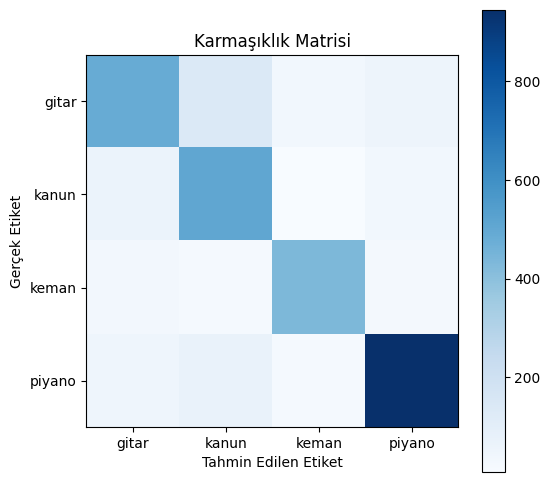

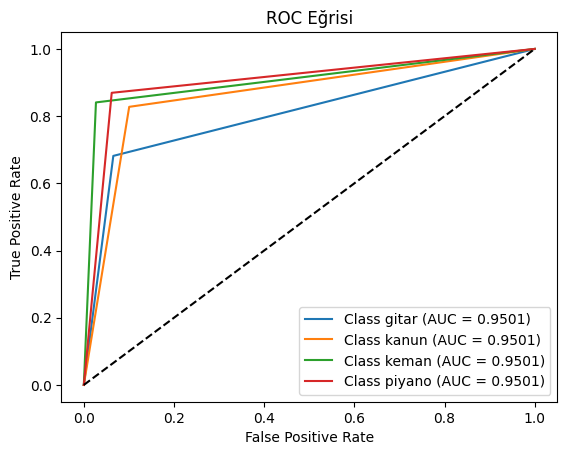

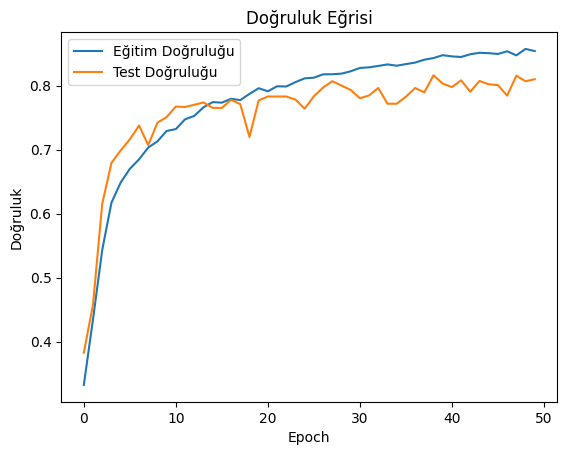

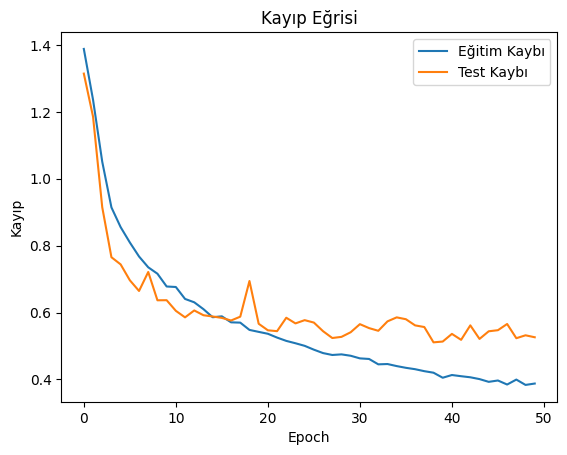

Çıkarım süresi: 1.2838 saniye
Eğitim süresi: 924.0358 saniye


In [2]:
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, Add, BatchNormalization, 
                                      Activation, Dropout, GlobalAveragePooling1D, Dense, LayerNormalization)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, roc_curve, auc)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Veriyi hazırlama
mfcc_data = []
labels = []

# Klasör isimleri ve etiketleri eşleştiren bir sözlük
enstruman_klasorleri = {
    "mfcc_cikti_gitar": "gitar",
    "mfcc_cikti_kanun": "kanun",
    "mfcc_cikti_keman": "keman",
    "mfcc_cikti_piyano": "piyano"
}

# Ana dizinin yolu
ana_dizin = r"C:\Users\Buse Yener\makineProje"

# Maksimum kare sayısını belirleme
TARGET_SHAPE = (100, 13)  # 100 zaman adımı, 13 MFCC katsayısı

# Her klasör için
for klasor, etiket in enstruman_klasorleri.items():
    klasor_yolu = os.path.join(ana_dizin, klasor)
    
    for dosya_adi in os.listdir(klasor_yolu):
        if dosya_adi.endswith(".npy"):
            dosya_yolu = os.path.join(klasor_yolu, dosya_adi)
            mfcc = np.load(dosya_yolu)
            
            if mfcc.shape[1] > TARGET_SHAPE[1]:
                mfcc = mfcc[:, :TARGET_SHAPE[1]]
            elif mfcc.shape[1] < TARGET_SHAPE[1]:
                padding_columns = np.zeros((mfcc.shape[0], TARGET_SHAPE[1] - mfcc.shape[1]))
                mfcc = np.hstack((mfcc, padding_columns))

            if mfcc.shape[0] > TARGET_SHAPE[0]:
                mfcc = mfcc[:TARGET_SHAPE[0], :]
            elif mfcc.shape[0] < TARGET_SHAPE[0]:
                padding_rows = np.zeros((TARGET_SHAPE[0] - mfcc.shape[0], TARGET_SHAPE[1]))
                mfcc = np.vstack((mfcc, padding_rows))
            
            mfcc_data.append(mfcc)
            labels.append(etiket)

mfcc_data = np.array(mfcc_data)
labels = np.array(labels)

# Etiketleri sayısal kodlama
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Veri setini eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(mfcc_data, encoded_labels, test_size=0.2, random_state=42)

# SMOTE ile veri dengesizliğini giderme
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train.reshape((X_train.shape[0], -1)), y_train)
X_train_smote = X_train_smote.reshape((X_train_smote.shape[0], TARGET_SHAPE[0], TARGET_SHAPE[1]))
X_test = X_test.reshape((X_test.shape[0], TARGET_SHAPE[0], TARGET_SHAPE[1]))

# Hubert benzeri blok tanımlama
def hubert_block(inputs, output_dim):
    x = Conv1D(filters=output_dim, kernel_size=3, padding="same")(inputs)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)

    shortcut = Dense(output_dim)(inputs)  # Boyut eşleştirme
    x = Add()([shortcut, x])
    x = Dropout(0.1)(x)
    return x

# Model oluşturma
input_layer = Input(shape=(TARGET_SHAPE[0], TARGET_SHAPE[1]))

x = hubert_block(input_layer, 64)
x = hubert_block(x, 128)
x = hubert_block(x, 256)

x = GlobalAveragePooling1D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output_layer = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Eğitim zamanı ölçümü
start_time = time.time()
history = model.fit(X_train_smote, y_train_smote, epochs=50, batch_size=32, validation_data=(X_test, y_test))
training_time = time.time() - start_time

# Çıkarım zamanı ölçümü
start_time = time.time()
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
inference_time = time.time() - start_time

# Performans metriklerini hesaplama
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# Karmaşıklık matrisi
cm = confusion_matrix(y_test, y_pred)

# Sensitivity ve Specificity hesaplama
avg_sensitivity = np.mean([cm[i, i] / (cm[i, i] + cm[i, 1:].sum()) for i in range(len(cm))])
avg_specificity = np.mean([cm[i, i] / (cm[i, i] + cm[1:, i].sum()) for i in range(len(cm))])

# Performans metriklerini yazdırma
print("Performans Metrikleri:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Average Sensitivity (Duyarlılık): {avg_sensitivity:.4f}")
print(f"Average Specificity (Özgüllük): {avg_specificity:.4f}")

# Karmaşıklık matrisi görselleştirme
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Karmaşıklık Matrisi")
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_)
plt.yticks(tick_marks, label_encoder.classes_)
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# ROC eğrisi
fpr = {}
tpr = {}
thresholds = {}
for i in range(4):
    fpr[i], tpr[i], thresholds[i] = roc_curve(tf.keras.utils.to_categorical(y_test, num_classes=4)[:, i], 
                                              tf.keras.utils.to_categorical(y_pred, num_classes=4)[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Eğrisi')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# Eğitim ve kayıp grafikleri
plt.figure()
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Test Doğruluğu')
plt.title('Doğruluk Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Test Kaybı')
plt.title('Kayıp Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Çıkarım zamanı
print(f"Çıkarım süresi: {inference_time:.4f} saniye")
print(f"Eğitim süresi: {training_time:.4f} saniye")
